The Marketing team is working with a third party platform to pull additional project information for each customer into our system.
They would like to ask your help to write a Python script to match the external company list with Toromont’s own customer list.
Please write a small Python script that performs the following tasks:
1.Ingest the customer and company lists
2.Match the company list and the customer list based on
    Name
    Phone number
    Address, in this order.
3.Export the result in a .csv file in the same folder.
Note: All the records are fictional, so do not worry if the result does not make sense. When submitting your assessment,
please include all .py files that support your assessment. You do not need to include the data files provided to solve this problem.
You may use any Python modules that you think will help solve this problem.

# Import Data

In [264]:
#import relevant libraries
import csv
import io
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import re

In [101]:
#Suppress warnings
import warnings
warnings.simplefilter("ignore")

In [211]:
#import company_list file
with open('company_list.csv') as my_input:
    data = [next(csv.reader(io.StringIO(line.replace('""', '"')))) for line in my_input]

company = pd.DataFrame(data[1:], columns=data[0])

#show first few rows
company.head(3)

,Company Name,Phone 1,Phone 2,Address,City,County,State,ZipCode,Related Projects,Total Project Value
0,"3 Round Stones, Inc",(705) 765-5706,(905) 717-1909,300 Dawson St N,BURLINGTON,HALTON,ONTARIO,M7B1H2,9,"$19,446,194"
1,48 Factoring Inc.,(611) 725-6775,(218) 725-2772,665 Millway Avenue Suite 47,QUEBEC,QUEBEC,QUEBEC,G5M 3P3,5,"$2,881,817"
2,5PSolutions,(516) 522-2121,(512) 522-7022,"3693 Colborne St. E,",LAVAL,LAVAL,QUEBEC,H2D 3T8,70,"$9,558,121"


In [212]:
#import customer_list file
with open ('customer_list.csv') as input2:
    data2 = [next(csv.reader(io.StringIO(line.replace('""', '"')))) for line in input2]

customer = pd.DataFrame(data2[1:], columns = data2[0])

#display first few rows
customer.head(3)

,Name,Phone,Address,
0,034578 NOVA SCOTIA O/A BIOVIA,7025655756,"723 TWISS , DARTMOUTH NS",
1,05763 ONTARIO O/A BEKINS,6505251770,"3613 ROUTE MARIE-VICTORIN , CALEDON ON",
2,"3 ROUND STONES, LTD.",7057655706,"300 DAWSON ST N , BURLINGTON ON",


# Data Exploration

In [215]:
#Explore the company data by clicking through topics and variables
pandas_profiling.ProfileReport(company)

In [218]:
#reindex the customer dataframe to fix column indexing error
customer = customer.reindex(columns=['Name', 'Phone', 'Address'])

In [219]:
#Explore the customer data by clicking through topics and variables
pandas_profiling.ProfileReport(customer)

It can be seen that we have similar data in different formats from the two sources, including upper and lower cases, punctuation marks, special characters, use of inc vs ltd etc. This means we have to clean our data before processing pattern similarity matching. It would also be smart to subset the desired data from the company dataframe according to requirements.

# Data Cleaning

In [104]:
#Make a subset of the desired features from the company dataframe
company_sub = company[['Company Name', 'Address', 'Phone 1', 'Phone 2', 'Total Project Value']]

In [105]:
#Dimensions
company_sub.shape

(529, 5)

In [106]:
#Show first few records
company_sub.head(3)

,Company Name,Address,Phone 1,Phone 2,Total Project Value
0,"3 Round Stones, Inc",300 Dawson St N,(705) 765-5706,(905) 717-1909,"$19,446,194"
1,48 Factoring Inc.,665 Millway Avenue Suite 47,(611) 725-6775,(218) 725-2772,"$2,881,817"
2,5PSolutions,"3693 Colborne St. E,",(516) 522-2121,(512) 522-7022,"$9,558,121"


In [107]:
#Remove special characters from different columns in the subset
company_sub['Company Name'] = company_sub['Company Name'].str.replace(r'[^\w\s]+', '')
company_sub['Address'] = company_sub['Address'].str.replace(r'[^\w\s]+', '')
company_sub['Phone 1'] = company_sub['Phone 1'].str.replace(r'[^\w\s]+', '')
company_sub['Phone 2'] = company_sub['Phone 2'].str.replace(r'[^\w\s]+', '')
company_sub['Total Project Value'] = company_sub['Total Project Value'].str.replace(r'[^\w\s]+', '')

#remove space between numbers in Phone 1
company_sub['Phone 1'] = company_sub['Phone 1'].str.replace(r' ', '')

#remove space between numbers in Phone 2
company_sub['Phone 2'] = company_sub['Phone 2'].str.replace(r' ', '')

In [108]:
#Glance
company_sub.head(3)

,Company Name,Address,Phone 1,Phone 2,Total Project Value
0,3 Round Stones Inc,300 Dawson St N,7057655706,9057171909,19446194
1,48 Factoring Inc,665 Millway Avenue Suite 47,6117256775,2187252772,2881817
2,5PSolutions,3693 Colborne St E,5165222121,5125227022,9558121


In [109]:
#Similarly, remove special characters from customer dataframe
customer['Name'] = customer['Name'].str.replace(r'[^\w\s]+', '')
customer['Address'] = customer['Address'].str.replace(r'[^\w\s]+', '')
customer['Phone'] = customer['Phone'].str.replace(r'[^\w\s]+', '')

In [110]:
#Glance
customer.head(3)

,Name,Phone,Address,
0,034578 NOVA SCOTIA OA BIOVIA,7025655756,723 TWISS DARTMOUTH NS,
1,05763 ONTARIO OA BEKINS,6505251770,3613 ROUTE MARIEVICTORIN CALEDON ON,
2,3 ROUND STONES LTD,7057655706,300 DAWSON ST N BURLINGTON ON,


In [111]:
#convert the address, companyname and name to lowercase for case uniformity
customer['Name'] = customer['Name'].map(lambda x: x.lower())
customer['Address'] = customer['Address'].map(lambda x: x.lower())
customer.head(3)

,Name,Phone,Address,
0,034578 nova scotia oa biovia,7025655756,723 twiss dartmouth ns,
1,05763 ontario oa bekins,6505251770,3613 route marievictorin caledon on,
2,3 round stones ltd,7057655706,300 dawson st n burlington on,


In [112]:
#similarly convert to lowercase
company_sub['Company Name'] = company_sub['Company Name'].map(lambda x: x.lower())
company_sub['Address'] = company_sub['Address'].map(lambda x: x.lower())
company_sub.head(3)

,Company Name,Address,Phone 1,Phone 2,Total Project Value
0,3 round stones inc,300 dawson st n,7057655706,9057171909,19446194
1,48 factoring inc,665 millway avenue suite 47,6117256775,2187252772,2881817
2,5psolutions,3693 colborne st e,5165222121,5125227022,9558121


In [113]:
#Remove ltd and inc from the company name for uniformity sake
strings_to_remove = ['inc', 'ltd']
company_sub['Company Name'] = company_sub['Company Name'].str.replace('|'.join(strings_to_remove), '', regex=True).str.strip()
company_sub.head(3)

,Company Name,Address,Phone 1,Phone 2,Total Project Value
0,3 round stones,300 dawson st n,7057655706,9057171909,19446194
1,48 factoring,665 millway avenue suite 47,6117256775,2187252772,2881817
2,5psolutions,3693 colborne st e,5165222121,5125227022,9558121


In [114]:
# Similarly remove ltd and inc from Name
customer['Name'] = customer['Name'].str.replace('|'.join(strings_to_remove), '', regex=True).str.strip()
customer.head(3)

,Name,Phone,Address,
0,034578 nova scotia oa biovia,7025655756,723 twiss dartmouth ns,
1,05763 ontario oa bekins,6505251770,3613 route marievictorin caledon on,
2,3 round stones,7057655706,300 dawson st n burlington on,


In [117]:
#remove the province codes from the customer address since there are no province codes in the Company Address we want to match
customer['Address'] = customer['Address'].str.rsplit(' ', 1).str[0]
customer.head(3)

,Name,Phone,Address,
0,034578 nova scotia oa biovia,7025655756,723 twiss dartmouth,
1,05763 ontario oa bekins,6505251770,3613 route marievictorin caledon,
2,3 round stones,7057655706,300 dawson st n burlington,


In [119]:
#remove city from the customer address since there is no city in the Company Address we want to match
customer['Address'] = customer['Address'].str.rsplit(' ', 1).str[0]
customer.head(3)

,Name,Phone,Address,
0,034578 nova scotia oa biovia,7025655756,723 twiss,
1,05763 ontario oa bekins,6505251770,3613 route marievictorin,
2,3 round stones,7057655706,300 dawson st n,


# Match and Merge

In [121]:
#Count of matching phone 1
customer['Phone'].isin(company_sub['Phone 1']).value_counts()

True     253
False    116
Name: Phone, dtype: int64

In [190]:
#Merge by Phone(1)
byphone_1 = pd.merge(company_sub[['Company Name', 'Total Project Value', 'Phone 1']],
                 customer[['Name','Phone']],
                 left_on='Phone 1', right_on='Phone')
#Glance
byphone_1.head(3)

,Company Name,Total Project Value,Phone 1,Name,Phone
0,3 round stones,19446194,7057655706,3 round stones,7057655706
1,abt associates,8774465,6155725760,abt associates,6155725760
2,accela,2578657,7052612106,accela,7052612106


In [192]:
#Rename the customer 'Name' column as ToromontName
byphone_1 = byphone_1.rename(columns = {'Name':'ToromontName'})

#Create a new column 'MatchingMethod'
byphone_1['MatchingMethod'] = 'By phone'

#Drop Phone and Phone 1 columns
byphone_1 = byphone_1.drop(['Phone 1','Phone'], axis = 1)

#Glance
byphone_1.head(3)

,Company Name,Total Project Value,ToromontName,MatchingMethod
0,3 round stones,19446194,3 round stones,By phone
1,abt associates,8774465,abt associates,By phone
2,accela,2578657,accela,By phone


In [122]:
#Count of matching phone numbers(2)
customer['Phone'].isin(company_sub['Phone 2']).value_counts()

False    362
True       7
Name: Phone, dtype: int64

In [193]:
#Merge by Phone(2)
byphone_2 = pd.merge(company_sub[['Company Name', 'Total Project Value', 'Phone 2']],
                 customer[['Name','Phone']],
                 left_on='Phone 2', right_on='Phone')
#Glance
byphone_2.head(3)

,Company Name,Total Project Value,Phone 2,Name,Phone
0,3 round stones,19446194,9057171909,3 round stones,9057171909
1,48 factoring,2881817,2187252772,48 factoring,2187252772
2,accenture,1927921,9051897277,accenture consulting,9051897277


In [194]:
#Rename the customer 'Name' column as ToromontName
byphone_2 = byphone_2.rename(columns = {'Name':'ToromontName'})

#Create a new column 'MatchingMethod'
byphone_2['MatchingMethod'] = 'By phone'

#Drop Phone and Phone 2 columns
byphone_2 = byphone_2.drop(['Phone 2','Phone'], axis = 1)

#Glance
byphone_2.head(3)

,Company Name,Total Project Value,ToromontName,MatchingMethod
0,3 round stones,19446194,3 round stones,By phone
1,48 factoring,2881817,48 factoring,By phone
2,accenture,1927921,accenture consulting,By phone


In [123]:
#Count of matching names
customer['Name'].isin(company_sub['Company Name']).value_counts()

False    217
True     152
Name: Name, dtype: int64

In [183]:
#Merge by name
byname=pd.merge(company_sub[['Company Name', 'Total Project Value']],
                 customer['Name'],
                 left_on='Company Name', right_on='Name',)
#Glance
byname.head(3)

,Company Name,Total Project Value,Name
0,3 round stones,19446194,3 round stones
1,3 round stones,19446194,3 round stones
2,48 factoring,2881817,48 factoring


In [184]:
#Rename the customer 'Name' column as ToromontName
byname = byname.rename(columns = {'Name':'ToromontName'})

#Create a new column 'MatchingMethod'
byname['MatchingMethod'] = 'By name'

#Glance
byname.head(3)

,Company Name,Total Project Value,ToromontName,MatchingMethod
0,3 round stones,19446194,3 round stones,By name
1,3 round stones,19446194,3 round stones,By name
2,48 factoring,2881817,48 factoring,By name


In [124]:
#Count of matching Addresses
customer['Address'].isin(company_sub['Address']).value_counts()

False    358
True      11
Name: Address, dtype: int64

In [180]:
#merge by address
byaddress = pd.merge(company_sub[['Company Name', 'Total Project Value', 'Address']],
                 customer[['Name', 'Address']],
                 on = ['Address', 'Address'])
#Glance
byaddress.head(3)

In [181]:
#Rename the customer 'Name' column as ToromontName
byaddress = byaddress.rename(columns = {'Name':'ToromontName'})

#Create a new column 'MatchingMethod'
byaddress['MatchingMethod'] = 'By address'

#Drop Address
byaddress = byaddress.drop(['Address'], axis = 1)

#Glance
byaddress.head(3)

,Company Name,Total Project Value,ToromontName,MatchingMethod
0,accuweather,18194998,amsterdam news,By address
1,accuweather,18194998,atsite,By address
2,accuweather,18194998,aunt bertha,By address


# Combine data

In [245]:
#combine all the dataframes into one row-wise since they all have the same columns
combined_data = pd.concat([byname, byphone_1, byphone_2, byaddress], ignore_index = True, sort = True)

#Rename the 'Company Name' as CompanyName and 'Total Project Value'as TotalProjectValue columns
combined_data = combined_data.rename(columns = {'Company Name':'CompanyName', 'Total Project Value':'TotalProjectValue'})

#change order of columns
combined_data = combined_data[['CompanyName','ToromontName','MatchingMethod','TotalProjectValue']]

#dimensions
print(byphone_1.shape, byphone_2.shape, byaddress.shape, byname.shape, combined_data.shape)

(259, 4) (7, 4) (209, 4) (152, 4) (627, 4)


You can see that the combined_data table has 627 records, which is more than the number of original records in either the company or customer file. This is due to records matching by more than one method or one to many matching. We are giving preference to matching by name then by phone and by address. For example, if records match by name, we don't need the duplicate matching by phone or address and consequently if we have a match by phone, there is no need for an additional matching by address. So, let's clean the combined_data table.

In [246]:
#checking for duplicate records matched by both name and phone
combined_data[(combined_data['CompanyName']==combined_data['ToromontName']) & (combined_data['MatchingMethod']=='By phone')]

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue
152,3 round stones,3 round stones,By phone,19446194
153,abt associates,abt associates,By phone,8774465
154,accela,accela,By phone,2578657
156,acxiom,acxiom,By phone,11999996
157,adaptive,adaptive,By phone,158992
...,...,...,...,...
410,zurich insurance risk room,zurich insurance risk room,By phone,1868111
411,3 round stones,3 round stones,By phone,19446194
412,48 factoring,48 factoring,By phone,2881817
415,acxiom,acxiom,By phone,11999996


There are 150 duplicate records. These are records that match both by name and phone. So, we will drop the duplicates.

In [247]:
#Drop duplicates matched by name and phone
combined_data. drop(combined_data[(combined_data['CompanyName']==combined_data['ToromontName']) & (combined_data['MatchingMethod']=='By phone')]. index, axis=0, inplace=True)
combined_data.shape

(477, 4)

In [229]:
#Now let's check for duplicate records matched by both name and address
combined_data[(combined_data['CompanyName']==combined_data['ToromontName']) & (combined_data['MatchingMethod']=='By address')]

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue
289,atsite,atsite,By address,6261647
301,aunt bertha,aunt bertha,By address,6726496
427,opportunityspace,opportunityspace,By address,641692
439,ranku,ranku,By address,14452491
451,redfin,redfin,By address,9985172


In [230]:
#Drop duplicates matched by name and address
combined_data. drop(combined_data[(combined_data['CompanyName']==combined_data['ToromontName']) & (combined_data['MatchingMethod']=='By address')]. index, axis=0, inplace=True)
combined_data.shape

(472, 4)

In [231]:
#Check for duplicates matched by phone and address
combined_data[(combined_data['MatchingMethod']=='By phone') & (combined_data['MatchingMethod']=='By Address')]

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue


In [251]:
# Return duplicate rows except first occurrence based on all columns
combined_data[combined_data.duplicated()]

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue
1,3 round stones,3 round stones,By name,19446194
6,acxiom,acxiom,By name,11999996
8,adaptive,adaptive,By name,158992
413,accenture,accenture consulting,By phone,1927921


We found some duplicated rows and we are going to drop them

In [252]:
#Drop duplicated rows
combined_data.drop(combined_data[combined_data.duplicated()].index, axis=0, inplace = True)

In [253]:
# Let's see the distribution by matching method
combined_data['MatchingMethod'].value_counts()

By address    209
By name       149
By phone      115
Name: MatchingMethod, dtype: int64

This is the number of matches by matching method


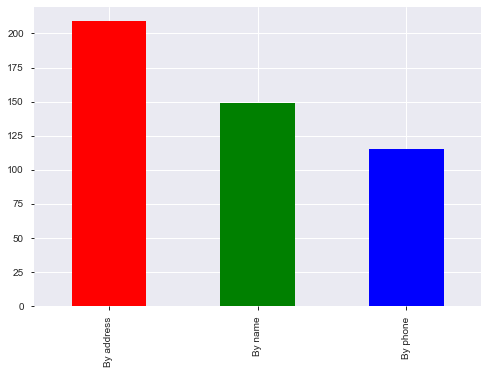

In [254]:
print('This is the number of matches by matching method')
combined_data['MatchingMethod'].value_counts().plot(kind = 'bar', color = list('rgbkymc'))

In [260]:
combined_data.head(3)

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue
0,3 round stones,3 round stones,By name,19446194
2,48 factoring,48 factoring,By name,2881817
3,abt associates,abt associates,By name,8774465


In [259]:
#sample the combined dataframe
combined_data.sample(frac=1)

,CompanyName,ToromontName,MatchingMethod,TotalProjectValue
125,trialtrove,trialtrove,By name,299998
529,jj keller,atsite,By address,4299214
83,relationship science,relationship science,By name,71895464
527,indoors,weatherco,By address,4476246
298,kimono labs,joseph notarianni co,By phone,147922
...,...,...,...,...
13,amazon web services,amazon web services,By name,8854415
262,govini,helco sales co,By phone,47179442
142,weather channel,weather channel,By name,244999998
459,aunt bertha,ranku,By address,6726496


In [261]:
#Shuffle data to mix distribution
combined_data_shuffle = combined_data.sample(frac=1).reset_index(drop=True)

# Export Data

In [262]:
combined_data_shuffle.to_csv('combined_data.csv', index = False)